In [1]:
import os

import numpy as np
import pandas as pd
import torch
import torch_geometric
from torch_geometric.data import Data, Dataset
from tqdm import tqdm
from dataset import ExpressionDataset
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from torch.nn import Linear, Softmax
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, GNNExplainer
from torch_geometric.nn import global_mean_pool

Torch version: 1.9.0+cu102
Cuda available: True
Torch geometric version: 1.7.1


In [2]:
dataset = ExpressionDataset("./data")

100%|██████████| 243531/243531 [00:15<00:00, 15499.58it/s]


In [3]:
from gcnmodel import GCN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=128, data=dataset).to(device)
print(model)

GCN(
  (conv1): SAGEConv(1, 128)
  (conv2): SAGEConv(128, 128)
  (conv3): SAGEConv(128, 128)
  (lin): Linear(in_features=128, out_features=7, bias=True)
  (softmax): Softmax(dim=1)
)


In [4]:
model.load_state_dict(torch.load('model_weightsjul22_max_pool.pth'))

<All keys matched successfully>

In [9]:
explainer = GNNExplainer(model, epochs=200)
data = dataset[0]
x, edge_index = data.x, data.edge_index
x = torch.reshape(x, (x.shape[0], 1))
x = x.type(torch.FloatTensor)
node_feat_mask, edge_mask = explainer.explain_graph(x, edge_index)

Explain graph: 100%|██████████| 200/200 [03:25<00:00,  1.03s/it]


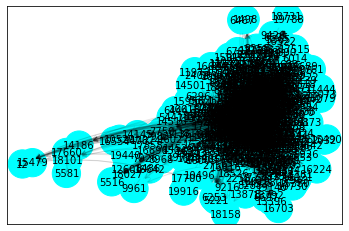

In [38]:
ax, G = explainer.visualize_subgraph(node_idx=12, edge_index=edge_index, edge_mask=edge_mask)

In [34]:
edge_mask.max()

tensor(0.1532)

In [22]:
dataset.cellToIndex

{'interneurons': 0,
 'pyramidal SS': 1,
 'pyramidal CA1': 2,
 'oligodendrocytes': 3,
 'microglia': 4,
 'endothelial-mural': 5,
 'astrocytes_ependymal': 6}

In [5]:
from torch_geometric.data import DataLoader
dataset = dataset.shuffle()
train_dataset = torch.load('trainDataset.pt')
test_dataset = torch.load('testDataset.pt')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print(len(test_loader))

602


In [6]:
def test(loader):
    model.eval()

    correct = 0
    avgAUC = 0
    toReturn = np.zeros((len(loader), 7))
    ind = 0
    actual = np.zeros((len(loader), 7))
    for data in loader:  # Iterate in batches over the training/test dataset.
        data.x = torch.reshape(data.x, (data.x.shape[0], 1))
        data.x = data.x.type(torch.FloatTensor)
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        toReturn[ind] = out.cpu().detach().numpy()
        actual[ind][data.y] = 1
        ind+=1
    return toReturn, actual

In [7]:
predics, test_labels = test(train_loader)

In [8]:
print(test_labels.shape)
print(predics.shape)

(2403, 7)
(2403, 7)


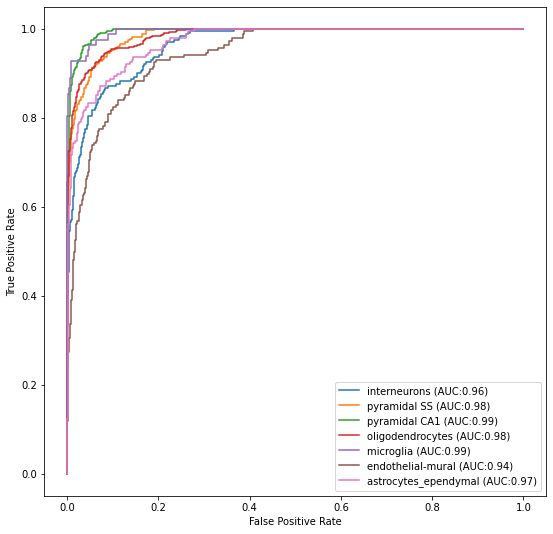

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

fig, c_ax = plt.subplots(1,1, figsize = (9, 9))

all_labels = list(dataset.cellToIndex.keys())
test_labels = np.array(test_labels)

for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_labels[:,idx].astype(int), predics[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_netWeights4.png')

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(predics, axis=1))

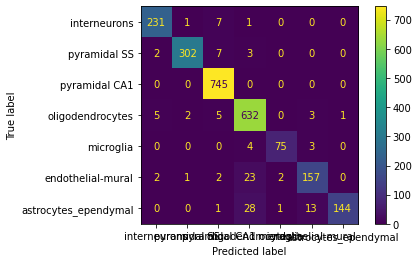

In [26]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dataset.cellToIndex.keys())
disp.plot()

In [21]:
np.argmax(test_labels, axis=1)

array([2, 2, 3, ..., 5, 2, 2])